### Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from hyperopt import hp
from lib.similarity import CentroidSimilarity
from utils.hyper_parameters_tuning import model_hypopt
from utils.visualization import plot_hist
from sklearn.neighbors import KNeighborsClassifier
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova,FeatureSelectionDiversityPursuitKruskal
from lib.classifier_with_feature_selection import ClassifierFeatureSelection
from utils.experiment_utils import multiple_classifiers_fit_predict
from utils.experiment_utils import get_feature_extractor, extract_features, preprocessing_model
from utils.experiment_utils import get_images_from_supervised_set
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from utils.visualization import bar_plot_scores
%load_ext autoreload
%autoreload 2

### Load dataset

In [2]:
datasets_dir = "c:/datasets/"
if os.path.isdir(datasets_dir) is not True:
    os.mkdir(datasets_dir)

In [3]:
ds_name = 'caltech_birds2011'
birds_ds, birds_ds_info = tfds.load(ds_name, split=['train', 'test'], shuffle_files=False, with_info=True, as_supervised=True,data_dir=datasets_dir)
print(birds_ds_info)

tfds.core.DatasetInfo(
    name='caltech_birds2011',
    full_name='caltech_birds2011/0.1.1',
    description="""
    Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
    of 200 bird species (mostly North American). The total number of 
    categories of birds is 200 and there are 6033 images in the 2010 
    dataset and 11,788 images in the 2011 dataset.
    Annotations include bounding boxes, segmentation labels.
    """,
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    data_path='c:/datasets/caltech_birds2011\\0.1.1',
    file_format=tfrecord,
    download_size=1.11 GiB,
    dataset_size=1.11 GiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=200),
        'label_name': Text(shape=(), dtype=string),
        'segmentation_mask': I

In [4]:
label_set = list(range(100))
train_images, train_labels = get_images_from_supervised_set(birds_ds[0], label_set)
print(f"images shape = {train_images.shape}")
print(f"labels shape = {train_labels.shape}")

images shape = (3000, 224, 224, 3)
labels shape = (3000,)


In [5]:
test_images, test_labels = get_images_from_supervised_set(birds_ds[1], label_set)
print(f"images shape = {test_images.shape}")
print(f"labels shape = {test_labels.shape}")

images shape = (2864, 224, 224, 3)
labels shape = (2864,)


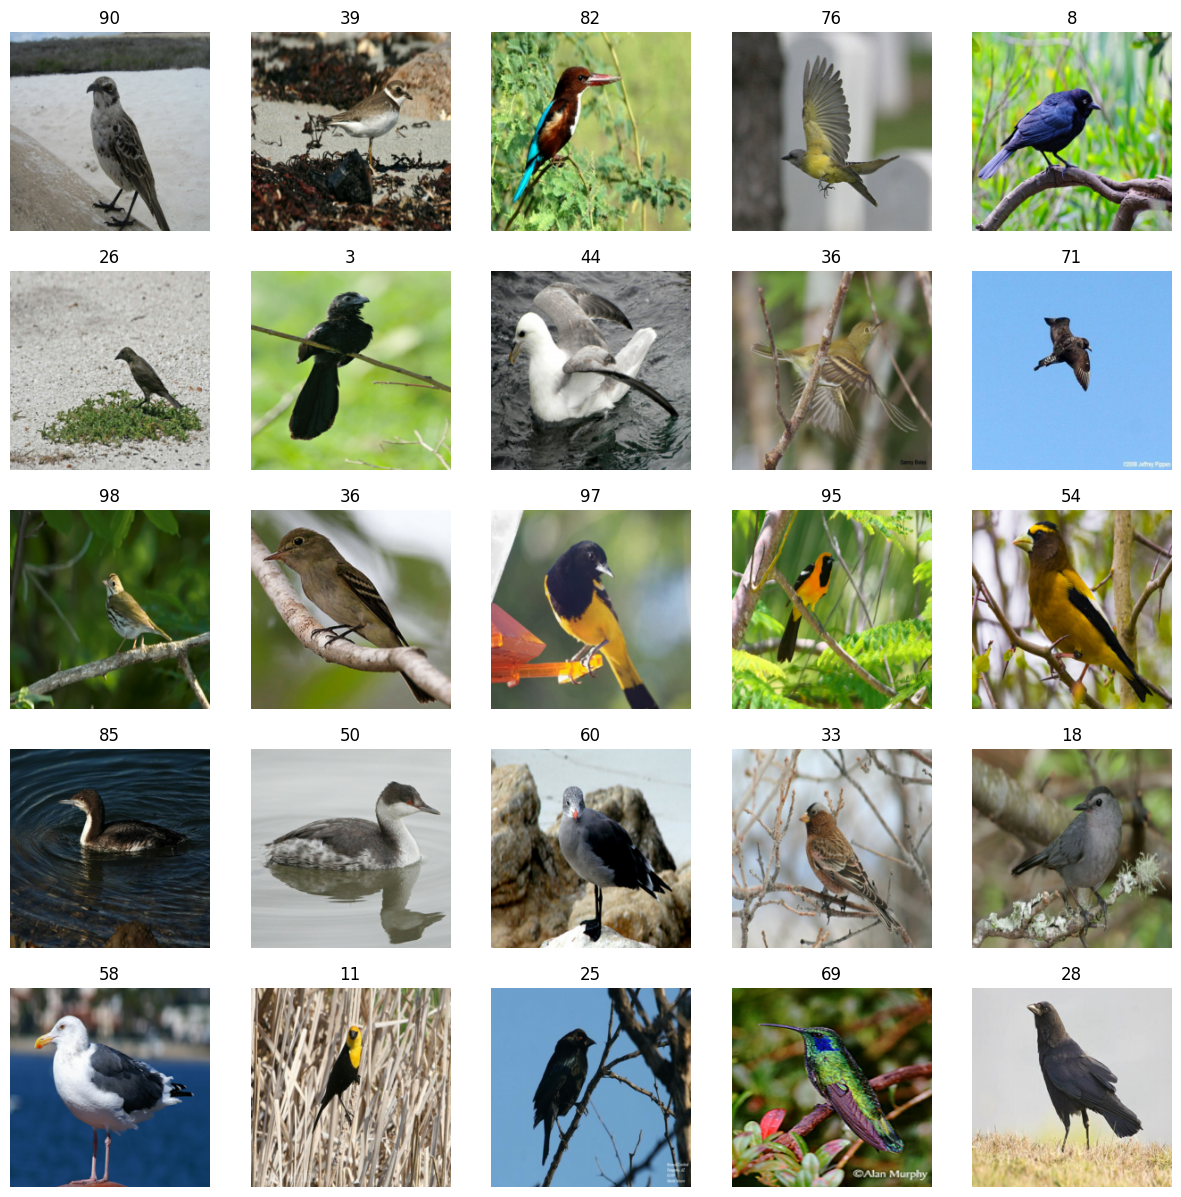

In [6]:
# plotting some examples from the data
plt.figure(figsize=(15, 15))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[i].numpy().astype("uint8"))
    ax.set_title(f"{test_labels[i]}")
    plt.axis("off")

### Define a noise function

In [7]:
# create an additive noise
def add_noise(images, threshold, noise_delta, low_sat, high_sat):
    mask = np.random.rand(*images.numpy().shape[0:3])
    mask = mask < threshold
    mask = np.repeat(np.expand_dims(mask,axis=3), 3, axis=3)
    noise = np.random.randint(low=-noise_delta, high=noise_delta, size=images.shape) * mask
    return np.clip(images+noise, a_min=low_sat, a_max=high_sat)

In [8]:
def resize_down_up(images,size):
    orig_size = [images.shape[1],images.shape[2]]
    small_images = tf.image.resize(images, size=size, antialias=True)
    return tf.image.resize(small_images, size=orig_size, antialias=True)

In [9]:
#train_noisy_images = add_noise(images=train_images, threshold=0.6, noise_delta=80, low_sat=0, high_sat=255)
#test_noisy_images  = add_noise(images=test_images,  threshold=0.6, noise_delta=80, low_sat=0, high_sat=255)
train_noisy_images = resize_down_up(images=train_images, size=[32,32])
test_noisy_images  = resize_down_up(images=test_images,  size=[32,32])

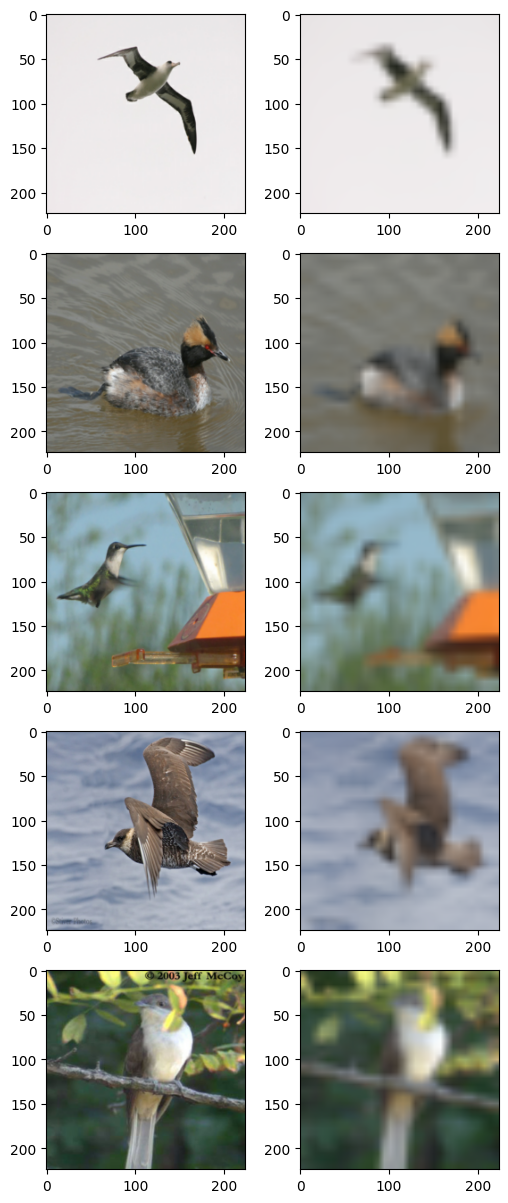

In [10]:
fig, ax = plt.subplots(5,2,figsize=(6, 15))
for i in range(5):
    ax[i,1].imshow(train_noisy_images[i].numpy().astype("uint8"))
    ax[i,0].imshow(train_images[i].numpy().astype("uint8"))


### Define a feature extractor

In [7]:
model_name = 'resnet50_v2'
# resnet_v2 expects pixel values in [-1, 1], but the pixel values in images are in [0, 255].
# To rescale them, use the preprocessing method included with the model.
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
# define an average pooling layer that will extract a single feature from each of the 2048 4x4 feature maps in the last layer of the base model
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# Create the base model from the pre-trained model
base_model = tf.keras.applications.ResNet50V2(input_shape=train_images.shape[1:],
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

### Extract features

In [8]:
preprocess = preprocessing_model(input_shape=train_images.shape[1:],
                                            preprocess_layer=preprocess_input,
                                            noise_model=None)
feature_extractor = get_feature_extractor(base_model=base_model, input_shape=train_images.shape[1:], pooling_layer=global_average_layer)

In [9]:
batch_size = 32
with tf.device('/cpu:0'):
    train_ds = tf.data.Dataset.from_tensor_slices(train_images).batch(batch_size)
    test_ds = tf.data.Dataset.from_tensor_slices(test_images).batch(batch_size)
X_train = extract_features(ds=train_ds, preprocessing_model=preprocess, feature_extractor=feature_extractor)
X_test  = extract_features(ds=test_ds, preprocessing_model=preprocess, feature_extractor=feature_extractor)

In [14]:
batch_size = 32
with tf.device('/cpu:0'):
    noisy_train_ds = tf.data.Dataset.from_tensor_slices(train_noisy_images).batch(batch_size)
    noisy_test_ds  = tf.data.Dataset.from_tensor_slices(test_noisy_images).batch(batch_size)
noisy_X_train = extract_features(ds=noisy_train_ds, preprocessing_model=preprocess, feature_extractor=feature_extractor)
noisy_X_test  = extract_features(ds=noisy_test_ds, preprocessing_model=preprocess, feature_extractor=feature_extractor)

In [10]:
if tf.is_tensor(train_labels):
    y_train = train_labels.numpy()
else:
    y_train = train_labels
if tf.is_tensor(test_labels):
    y_test = test_labels.numpy()
else:
    y_test = test_labels
print(f"labels = {np.unique(y_train)}")


labels = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


### Experiment 1 - scanning train set size

In [16]:
# optimize a SVM classifier to the train data
svm_search_space = {'C' : hp.uniform('C',0.1,10),
                        'kernel': hp.choice('kernel',['linear', 'poly', 'rbf', 'sigmoid']),
                        'degree' : hp.choice('degree',list(range(1,10)))}
# sample a label set
label_set = np.random.choice(a=np.unique(y_train),size=5,replace=False)
smpl_idx = []
for l in label_set:
    cls_idcs = np.squeeze(np.argwhere(y_train == l))
    smpl_idx.extend(list(cls_idcs))
svm_X_train = X_train[smpl_idx]
svm_y_train = y_train[smpl_idx]

hyper_opt = model_hypopt(model=SVC,param_space=svm_search_space,X_train=svm_X_train, y_train=svm_y_train)
best_params = hyper_opt.run()

100%|██████████| 150/150 [00:05<00:00, 26.10trial/s, best loss: -0.9533333333333334]


In [23]:
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova, FeatureSelectionDiversityPursuitPermutation
gamma = 0.5
train_sizes = [5,10,20]
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitAnova(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
dp_perm_fs = FeatureSelectionDiversityPursuitPermutation(hc_gamma=gamma, n_resamples=5000)
# defining classifiers
cs_cls  = CentroidSimilarity()
cs_fs_dp = ClassifierFeatureSelection(cs_cls, dp_fs)
#cs_fs_dp_perm = ClassifierFeatureSelection(cs_cls, dp_perm_fs)
cs_fs_ova = ClassifierFeatureSelection(cs_cls, ova_fs)
knn_cls = KNeighborsClassifier(n_neighbors=train_sizes[0])
knn_fs_dp = ClassifierFeatureSelection(knn_cls, dp_fs)
knn_fs_ova = ClassifierFeatureSelection(knn_cls, ova_fs)
svm_cls = SVC(**best_params)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova, knn_cls, knn_fs_dp, knn_fs_ova, svm_cls]
num_experiments = 50
# define possible sizes for the train set (number of train examples per class)
num_classes = 10
accuracies = np.empty((len(classifiers),len(train_sizes),num_experiments))
accuracies_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))

for i in range(len(train_sizes)):
    n = train_sizes[i]
    print(f"Measuring accuracy with {num_classes} classes,  {n} training examples per class")
    print("---------------------------------------------------------------")
    for j in range(num_experiments):
        # sample a label set
        label_set = np.random.choice(a=np.unique(y_train),size=num_classes,replace=False)
        # sample a desired number of examples (feature vectors) for each class
        smpl_idx = []
        test_idcs = []
        for l in label_set:
            cls_idcs = np.squeeze(np.argwhere(y_train == l))
            smpl_idx.extend(list(np.random.choice(cls_idcs,n,replace=False)))
            test_idcs.extend(np.squeeze(np.argwhere(y_test == l)))
        smpl_X_train = X_train[smpl_idx]
        smpl_y_train = y_train[smpl_idx]
        exp_X_test = X_test[test_idcs]
        exp_y_test = y_test[test_idcs]
        accuracies[:,i,j], num_features[:,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers, X_train=smpl_X_train, y_train=smpl_y_train, X_test=exp_X_test, y_test=exp_y_test)

        noisy_smpl_X_train = noisy_X_train[smpl_idx]
        noisy_exp_X_test = noisy_X_test[test_idcs]

        accuracies_w_noise[:,i,j], num_features_w_noise[:,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers, X_train=noisy_smpl_X_train, y_train=smpl_y_train, X_test=noisy_exp_X_test, y_test=exp_y_test)

    print("\n\n\n")

Measuring accuracy with 10 classes,  5 training examples per class
---------------------------------------------------------------




Measuring accuracy with 10 classes,  10 training examples per class
---------------------------------------------------------------




Measuring accuracy with 10 classes,  20 training examples per class
---------------------------------------------------------------






#### Display accuracies

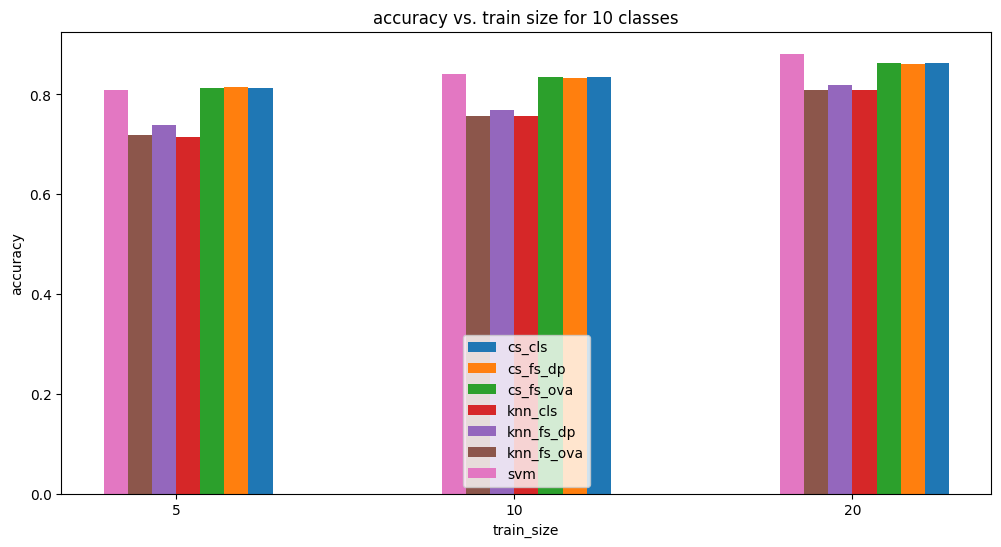

In [24]:
# plotting results for the clean data
from utils.visualization import bar_plot_scores
bar_labels = ['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'knn_cls', 'knn_fs_dp', 'knn_fs_ova', 'svm']
bar_plot_scores(scores=np.mean(accuracies,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='accuracy',
                title=f'accuracy vs. train size for {num_classes} classes')

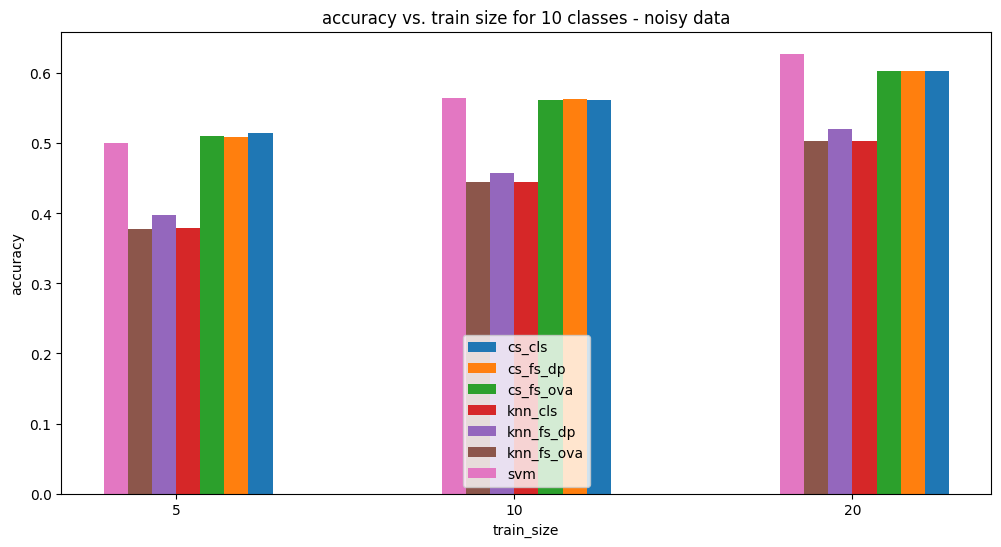

In [25]:
# plotting results for the noisy data
from utils.visualization import bar_plot_scores
bar_plot_scores(scores=np.mean(accuracies_w_noise,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='accuracy',
                title=f'accuracy vs. train size for {num_classes} classes - noisy data')

#### Display numbers of selected features

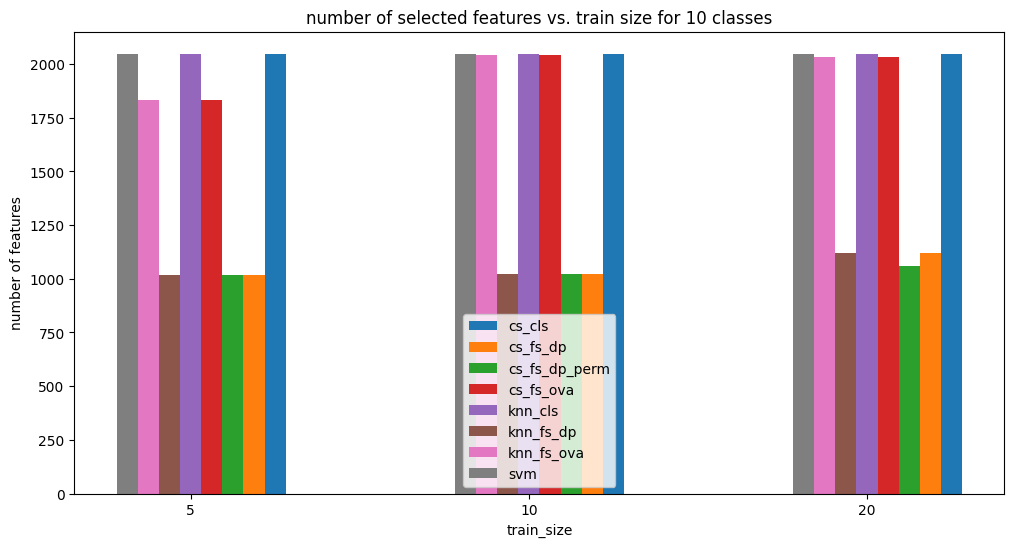

In [20]:
# plotting results for the clean data
from utils.visualization import bar_plot_scores
bar_plot_scores(scores=np.mean(num_features,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='number of features',
                title=f'number of selected features vs. train size for {num_classes} classes')

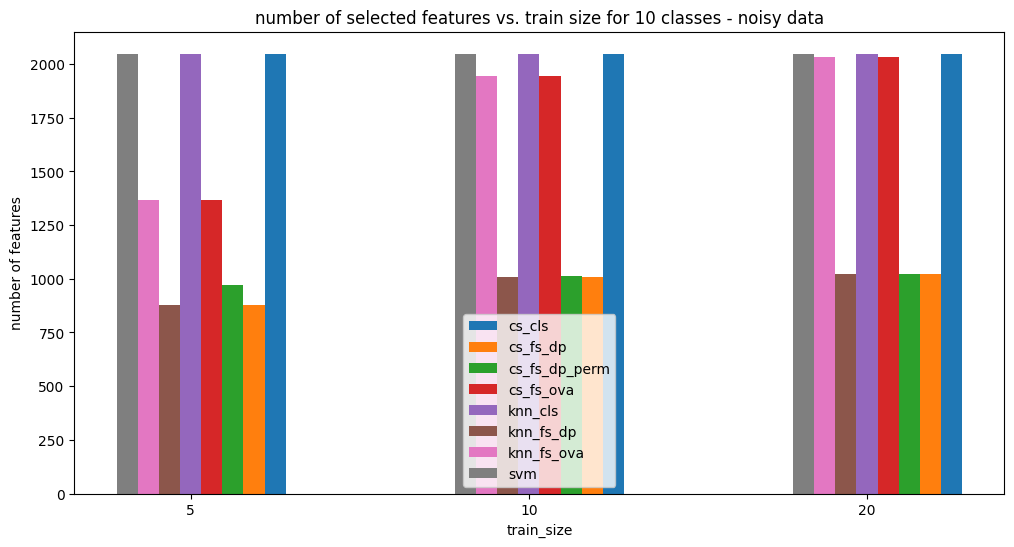

In [21]:
# plotting results for the noisy data
from utils.visualization import bar_plot_scores
bar_plot_scores(scores=np.mean(num_features_w_noise,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='number of features',
                title=f'number of selected features vs. train size for {num_classes} classes - noisy data')

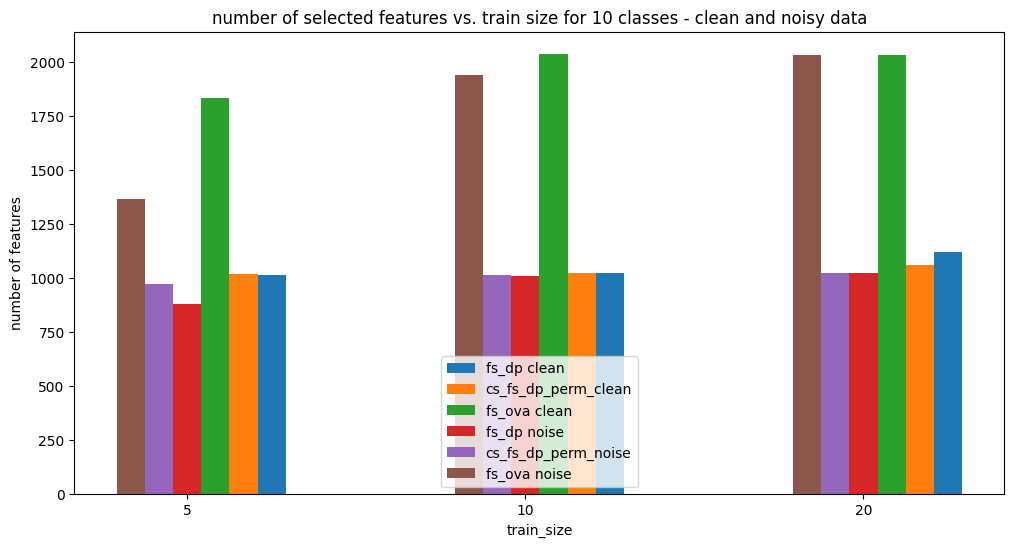

In [22]:
# show the number of features from the clean and the noisy data side by side
num_features_agg = np.concatenate((num_features[[1,2,3],:,:], num_features_w_noise[[1,2,3],:,:]), axis=0)
bar_plot_scores(scores=np.mean(num_features_agg,axis=2),
                bar_labels=['fs_dp clean', 'fs_ova clean', 'fs_dp noise', 'fs_ova noise'],
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='number of features',
                title=f'number of selected features vs. train size for {num_classes} classes - clean and noisy data')

### Experiment 2 - scan the number of classes

Measuring accuracy with 5 classes,  10 training examples per class
---------------------------------------------------------------




Measuring accuracy with 10 classes,  10 training examples per class
---------------------------------------------------------------




Measuring accuracy with 20 classes,  10 training examples per class
---------------------------------------------------------------






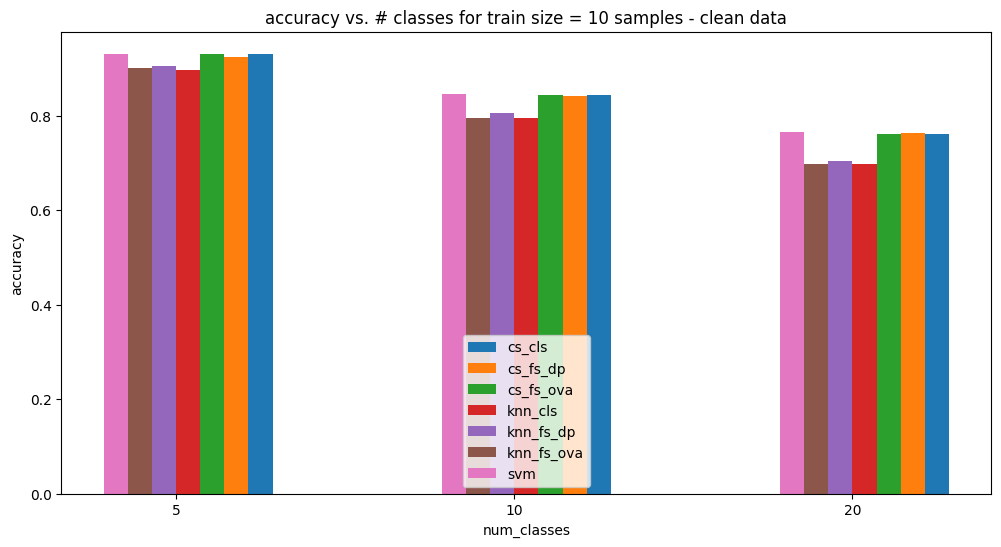

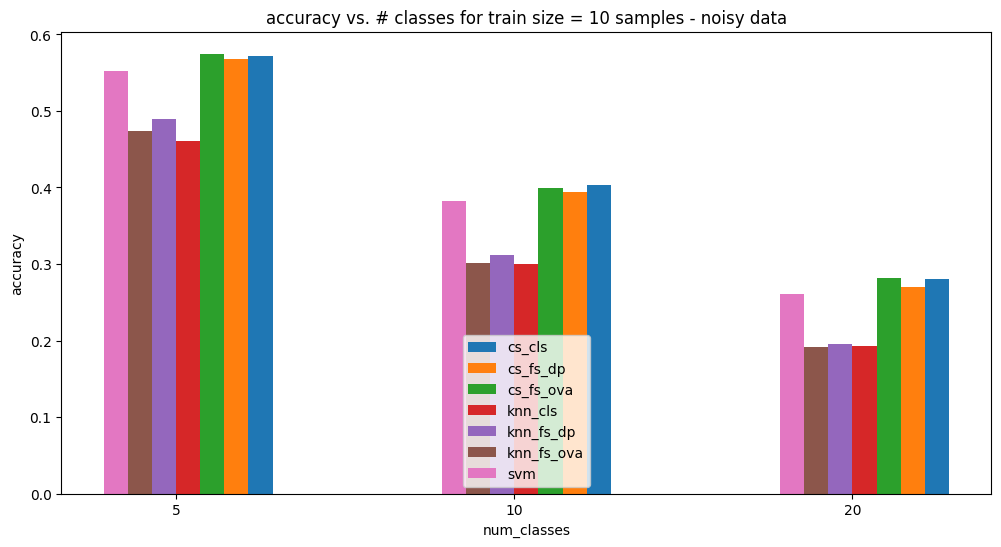

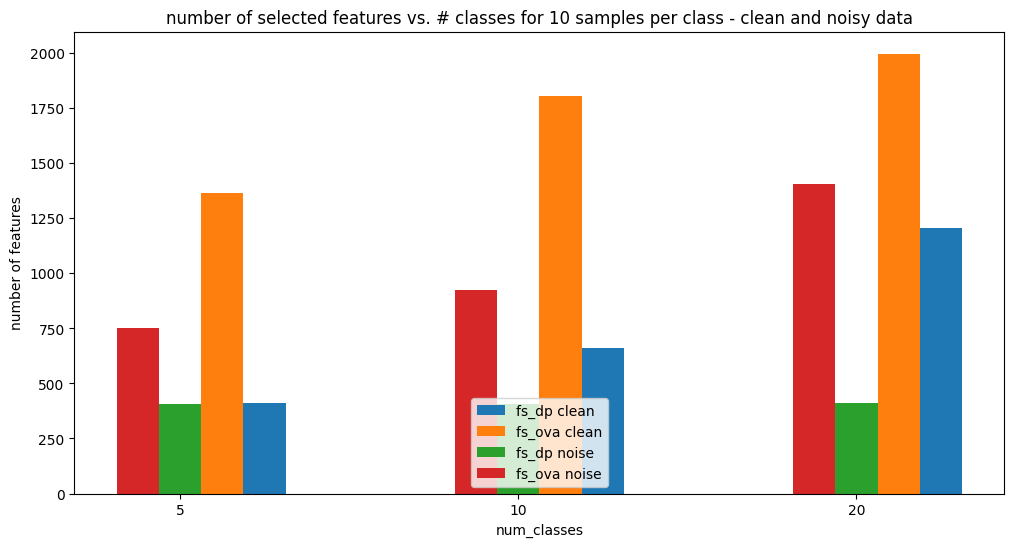

In [44]:
gamma = 0.2
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitKruskal(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
# defining classifiers
cs_cls  = CentroidSimilarity()
cs_fs_dp = ClassifierFeatureSelection(cs_cls, dp_fs)
cs_fs_ova = ClassifierFeatureSelection(cs_cls, ova_fs)
knn_cls = KNeighborsClassifier(n_neighbors=5)
knn_fs_dp = ClassifierFeatureSelection(knn_cls, dp_fs)
knn_fs_ova = ClassifierFeatureSelection(knn_cls, ova_fs)
svm_cls = SVC(**best_params)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova, knn_cls, knn_fs_dp, knn_fs_ova, svm_cls]
num_experiments = 50
# define possible sizes for the train set (number of train examples per class)
train_size = 10
num_classes = [5,10,20]
accuracies = np.empty((len(classifiers),len(train_sizes),num_experiments))
accuracies_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))

for i in range(len(num_classes)):
    n = train_size
    print(f"Measuring accuracy with {num_classes[i]} classes,  {n} training examples per class")
    print("---------------------------------------------------------------")
    for j in range(num_experiments):
        # sample a label set
        label_set = np.random.choice(a=np.unique(y_train),size=num_classes[i],replace=False)
        # sample a desired number of examples (feature vectors) for each class
        smpl_idx = []
        test_idcs = []
        for l in label_set:
            cls_idcs = np.squeeze(np.argwhere(y_train == l))
            smpl_idx.extend(list(np.random.choice(cls_idcs,n,replace=False)))
            test_idcs.extend(np.squeeze(np.argwhere(y_test == l)))
        smpl_X_train = X_train[smpl_idx]
        smpl_y_train = y_train[smpl_idx]
        exp_X_test = X_test[test_idcs]
        exp_y_test = y_test[test_idcs]
        accuracies[:,i,j], num_features[:,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers, X_train=smpl_X_train, y_train=smpl_y_train, X_test=exp_X_test, y_test=exp_y_test)

        noisy_smpl_X_train = noisy_X_train[smpl_idx]
        noisy_exp_X_test = noisy_X_test[test_idcs]

        accuracies_w_noise[:,i,j], num_features_w_noise[:,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers, X_train=noisy_smpl_X_train, y_train=smpl_y_train, X_test=noisy_exp_X_test, y_test=exp_y_test)

    print("\n\n\n")

# plotting results for the clean data
bar_plot_scores(scores=np.mean(accuracies,axis=2),
                bar_labels=['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'knn_cls', 'knn_fs_dp', 'knn_fs_ova', 'svm'],
                xticklabels=num_classes,
                xlabel='num_classes',
                ylabel='accuracy',
                title=f'accuracy vs. # classes for train size = {train_size} samples - clean data')

# and the noisy data
bar_plot_scores(scores=np.mean(accuracies_w_noise,axis=2),
                bar_labels=['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'knn_cls', 'knn_fs_dp', 'knn_fs_ova', 'svm'],
                xticklabels=num_classes,
                xlabel='num_classes',
                ylabel='accuracy',
                title=f'accuracy vs. # classes for train size = {train_size} samples - noisy data')

# show the number of features from the clean and the noisy data side by side
num_features_agg = np.concatenate((num_features[[1,2],:,:], num_features_w_noise[[1,2],:,:]), axis=0)
bar_plot_scores(scores=np.mean(num_features_agg,axis=2),
                bar_labels=['fs_dp clean', 'fs_ova clean', 'fs_dp noise', 'fs_ova noise'],
                xticklabels=num_classes,
                xlabel='num_classes',
                ylabel='number of features',
                title=f'number of selected features vs. # classes for {train_size} samples per class - clean and noisy data')

### Experiment 3 - Scan noise levels

In [41]:
use_additive_noise = False
# define noise profiles
if use_additive_noise:
    noise_profiles = {'th'  : [1 , 1 , 1 , 1  , 1  , 1],
                  'var' : [50, 70, 90, 110, 130, 150]}
    xticklabels = [f'th = {noise_profiles["th"][i]}, var = {noise_profiles["var"][i]}' for i in range(len(noise_profiles['th']))]
    num_noise_profiles = len(noise_profiles["th"])
else:
    noise_profiles = {'size' : [128,64,32,24,16]}
    xticklabels = [f'small image size= {noise_profiles["size"][i]}' for i in range(len(noise_profiles['size']))]
    num_noise_profiles = len(noise_profiles["size"])


Measuring accuracy with noise profile small image size= 128
---------------------------------------------------------------
adding noise to images...
extracting features from noisy images...
running experiments....




Measuring accuracy with noise profile small image size= 64
---------------------------------------------------------------
adding noise to images...
extracting features from noisy images...
running experiments....




Measuring accuracy with noise profile small image size= 32
---------------------------------------------------------------
adding noise to images...
extracting features from noisy images...
running experiments....




Measuring accuracy with noise profile small image size= 24
---------------------------------------------------------------
adding noise to images...
extracting features from noisy images...
running experiments....




Measuring accuracy with noise profile small image size= 16
---------------------------------------------------------------
addi

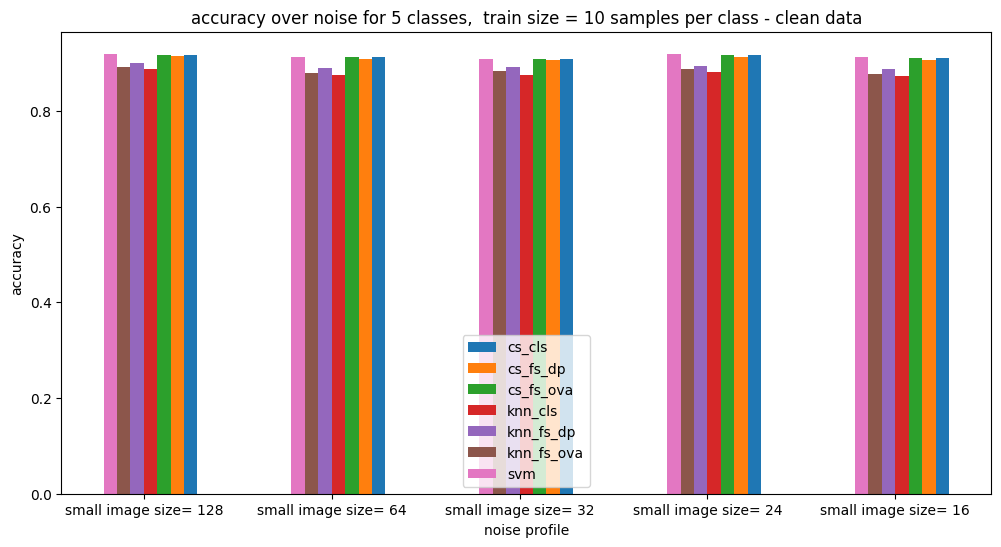

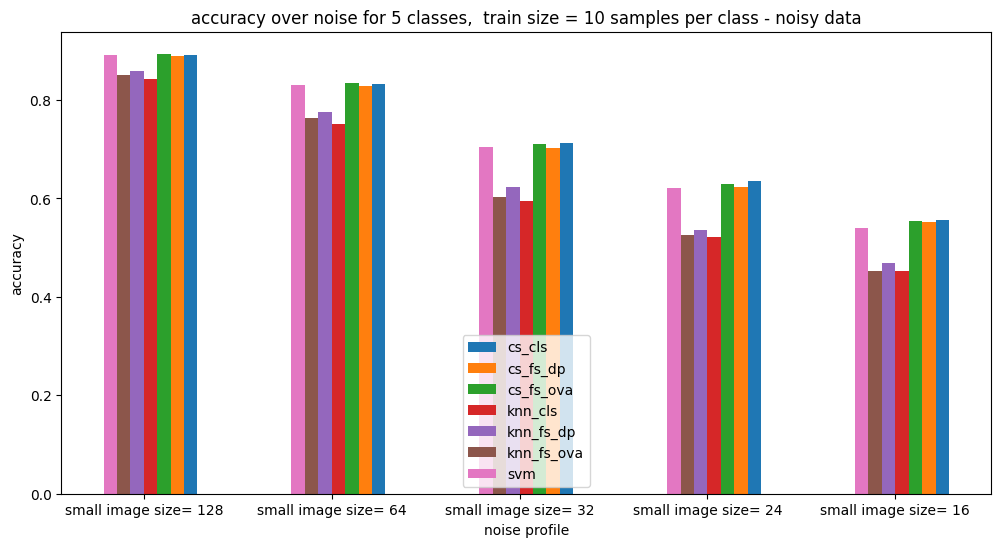

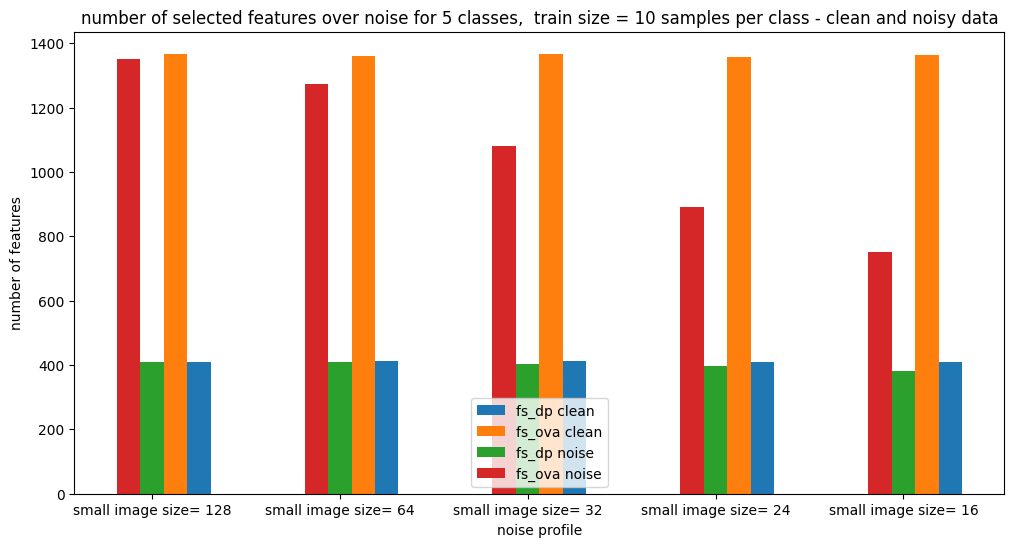

In [42]:
gamma = 0.2
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitAnova(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
# defining classifiers
cs_cls  = CentroidSimilarity()
cs_fs_dp = ClassifierFeatureSelection(cs_cls, dp_fs)
cs_fs_ova = ClassifierFeatureSelection(cs_cls, ova_fs)
knn_cls = KNeighborsClassifier(n_neighbors=5)
knn_fs_dp = ClassifierFeatureSelection(knn_cls, dp_fs)
knn_fs_ova = ClassifierFeatureSelection(knn_cls, ova_fs)
svm_cls = SVC(**best_params)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova, knn_cls, knn_fs_dp, knn_fs_ova, svm_cls]
num_experiments = 100
# define possible sizes for the train set (number of train examples per class)
train_size  = 10
num_classes = 5
accuracies = np.empty((len(classifiers),num_noise_profiles,num_experiments))
accuracies_w_noise = np.empty_like(accuracies)
num_features = np.empty_like(accuracies)
num_features_w_noise = np.empty_like(accuracies)

for i in range(num_noise_profiles):

    print(f"Measuring accuracy with noise profile {xticklabels[i]}")
    print("---------------------------------------------------------------")
    print("adding noise to images...")
    if use_additive_noise:
        train_noisy_images = add_noise(images=train_images, threshold=noise_profiles['th'][i], noise_delta=noise_profiles['var'][i], low_sat=0, high_sat=255)
        test_noisy_images  = add_noise(images=test_images,  threshold=noise_profiles['th'][i], noise_delta=noise_profiles['var'][i], low_sat=0, high_sat=255)
    else:
        train_noisy_images = resize_down_up(images=train_images, size=[noise_profiles['size'][i],noise_profiles['size'][i]])
        test_noisy_images  = resize_down_up(images=test_images,  size=[noise_profiles['size'][i],noise_profiles['size'][i]])
    print("extracting features from noisy images...")
    batch_size = 32
    with tf.device('/cpu:0'):
        noisy_train_ds = tf.data.Dataset.from_tensor_slices(train_noisy_images).batch(batch_size)
        noisy_test_ds  = tf.data.Dataset.from_tensor_slices(test_noisy_images).batch(batch_size)
    noisy_X_train = extract_features(ds=noisy_train_ds, preprocessing_model=preprocess, feature_extractor=feature_extractor)
    noisy_X_test  = extract_features(ds=noisy_test_ds, preprocessing_model=preprocess, feature_extractor=feature_extractor)
    print("running experiments....")
    for j in range(num_experiments):
        # sample a label set
        label_set = np.random.choice(a=np.unique(y_train),size=num_classes,replace=False)
        # sample a desired number of examples (feature vectors) for each class
        smpl_idx = []
        test_idcs = []
        for l in label_set:
            cls_idcs = np.squeeze(np.argwhere(y_train == l))
            smpl_idx.extend(list(np.random.choice(cls_idcs,train_size,replace=False)))
            test_idcs.extend(np.squeeze(np.argwhere(y_test == l)))
        smpl_X_train = X_train[smpl_idx]
        smpl_y_train = y_train[smpl_idx]
        exp_X_test = X_test[test_idcs]
        exp_y_test = y_test[test_idcs]
        accuracies[:,i,j], num_features[:,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers, X_train=smpl_X_train, y_train=smpl_y_train, X_test=exp_X_test, y_test=exp_y_test)

        noisy_smpl_X_train = noisy_X_train[smpl_idx]
        noisy_exp_X_test = noisy_X_test[test_idcs]

        accuracies_w_noise[:,i,j], num_features_w_noise[:,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers, X_train=noisy_smpl_X_train, y_train=smpl_y_train, X_test=noisy_exp_X_test, y_test=exp_y_test)

    print("\n\n\n")

# plotting results for the clean data
bar_plot_scores(scores=np.mean(accuracies,axis=2),
                bar_labels=['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'knn_cls', 'knn_fs_dp', 'knn_fs_ova', 'svm'],
                xticklabels=xticklabels,
                xlabel='noise profile',
                ylabel='accuracy',
                title=f'accuracy over noise for {num_classes} classes,  train size = {train_size} samples per class - clean data')

# and the noisy data
bar_plot_scores(scores=np.mean(accuracies_w_noise,axis=2),
                bar_labels=['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'knn_cls', 'knn_fs_dp', 'knn_fs_ova', 'svm'],
                xticklabels=xticklabels,
                xlabel='noise profile',
                ylabel='accuracy',
                title=f'accuracy over noise for {num_classes} classes,  train size = {train_size} samples per class - noisy data')

# show the number of features from the clean and the noisy data side by side
num_features_agg = np.concatenate((num_features[[1,2],:,:], num_features_w_noise[[1,2],:,:]), axis=0)
bar_plot_scores(scores=np.mean(num_features_agg,axis=2),
                bar_labels=['fs_dp clean', 'fs_ova clean', 'fs_dp noise', 'fs_ova noise'],
                xticklabels=xticklabels,
                xlabel='noise profile',
                ylabel='number of features',
                title=f'number of selected features over noise for {num_classes} classes,  train size = {train_size} samples per class - clean and noisy data')

### Experiment 4 - classification on "hard to classify" labels

In [27]:
# optimize a SVM classifier to the train data
svm_search_space = {'C' : hp.uniform('C',0.1,10),
                        'kernel': hp.choice('kernel',['linear', 'poly', 'rbf', 'sigmoid']),
                        'degree' : hp.choice('degree',list(range(1,10)))}
hyper_opt = model_hypopt(model=SVC,param_space=svm_search_space,X_train=X_train, y_train=y_train)
best_params = hyper_opt.run()
ref_model = SVC(**best_params)
ref_model.fit(X_train, y_train)
ref_model_pred = ref_model.predict(X_test)
ref_model_acc = accuracy_score(y_test, ref_model_pred)

100%|██████████| 150/150 [1:02:58<00:00, 25.19s/trial, best loss: -0.6380000000000001]


In [38]:
class_report_dict = classification_report(y_test, ref_model_pred, output_dict=True)
threshold = 0.35
low_recall_classes = [c for c in list(np.unique(y_test)) if class_report_dict[str(c)]['recall'] < threshold]
print(low_recall_classes)

[8, 25, 26, 28, 29, 42, 58, 96]


Measuring accuracy with 5 classes,  5 training examples per class
---------------------------------------------------------------




Measuring accuracy with 5 classes,  10 training examples per class
---------------------------------------------------------------




Measuring accuracy with 5 classes,  20 training examples per class
---------------------------------------------------------------






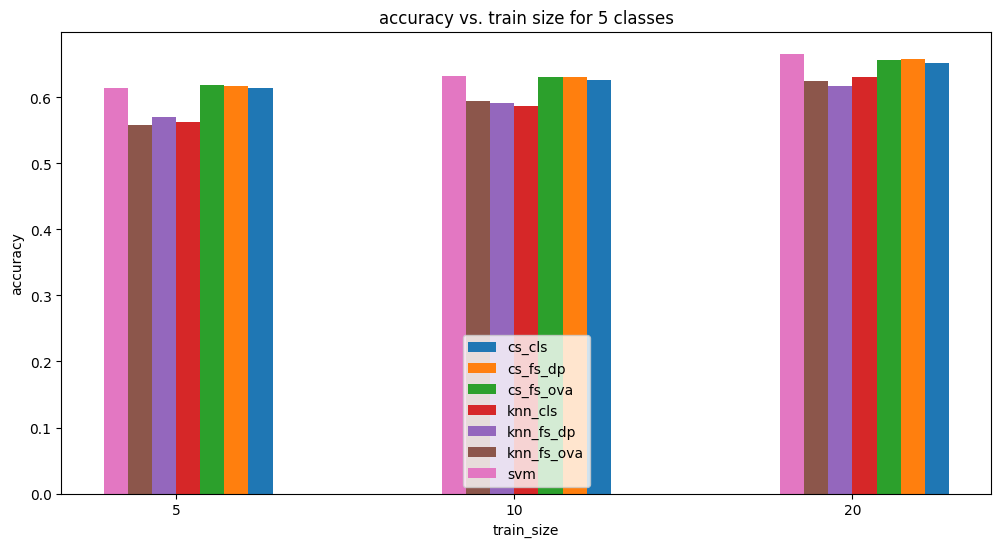

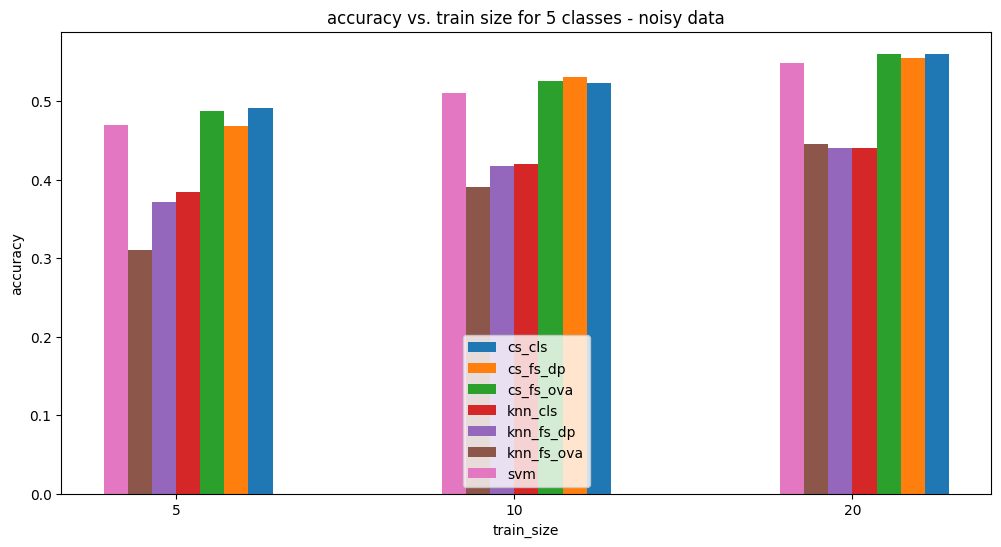

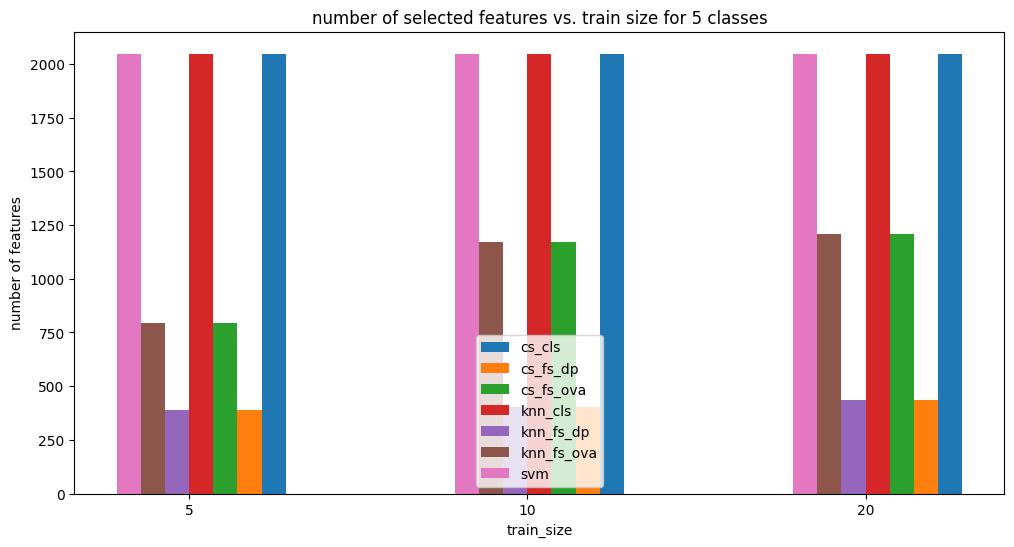

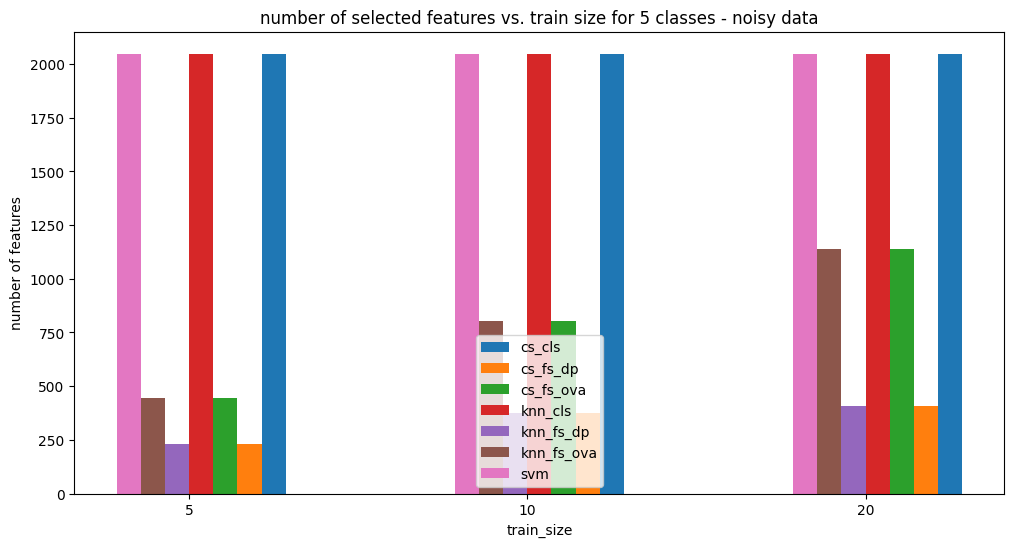

In [40]:
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova, FeatureSelectionDiversityPursuitPermutation
gamma = 0.2
train_sizes = [5,10,20]
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitAnova(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
dp_perm_fs = FeatureSelectionDiversityPursuitPermutation(hc_gamma=gamma, n_resamples=5000)
# defining classifiers
cs_cls  = CentroidSimilarity()
cs_fs_dp = ClassifierFeatureSelection(cs_cls, dp_fs)
#cs_fs_dp_perm = ClassifierFeatureSelection(cs_cls, dp_perm_fs)
cs_fs_ova = ClassifierFeatureSelection(cs_cls, ova_fs)
knn_cls = KNeighborsClassifier(n_neighbors=train_sizes[0])
knn_fs_dp = ClassifierFeatureSelection(knn_cls, dp_fs)
knn_fs_ova = ClassifierFeatureSelection(knn_cls, ova_fs)
svm_cls = SVC(**best_params)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova, knn_cls, knn_fs_dp, knn_fs_ova, svm_cls]
num_experiments = 50
# define possible sizes for the train set (number of train examples per class)
num_classes = 5
accuracies = np.empty((len(classifiers),len(train_sizes),num_experiments))
accuracies_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))

for i in range(len(train_sizes)):
    n = train_sizes[i]
    print(f"Measuring accuracy with {num_classes} classes,  {n} training examples per class")
    print("---------------------------------------------------------------")
    for j in range(num_experiments):
        # sample a label set
        label_set = np.random.choice(a=low_recall_classes,size=num_classes,replace=False)
        # sample a desired number of examples (feature vectors) for each class
        smpl_idx = []
        test_idcs = []
        for l in label_set:
            cls_idcs = np.squeeze(np.argwhere(y_train == l))
            smpl_idx.extend(list(np.random.choice(cls_idcs,n,replace=False)))
            test_idcs.extend(np.squeeze(np.argwhere(y_test == l)))
        smpl_X_train = X_train[smpl_idx]
        smpl_y_train = y_train[smpl_idx]
        exp_X_test = X_test[test_idcs]
        exp_y_test = y_test[test_idcs]
        accuracies[:,i,j], num_features[:,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers, X_train=smpl_X_train, y_train=smpl_y_train, X_test=exp_X_test, y_test=exp_y_test)

        noisy_smpl_X_train = noisy_X_train[smpl_idx]
        noisy_exp_X_test = noisy_X_test[test_idcs]

        accuracies_w_noise[:,i,j], num_features_w_noise[:,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers, X_train=noisy_smpl_X_train, y_train=smpl_y_train, X_test=noisy_exp_X_test, y_test=exp_y_test)

    print("\n\n\n")

# plotting results for the clean data
from utils.visualization import bar_plot_scores
bar_labels = ['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'knn_cls', 'knn_fs_dp', 'knn_fs_ova', 'svm']
bar_plot_scores(scores=np.mean(accuracies,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='accuracy',
                title=f'accuracy vs. train size for {num_classes} classes')

# plotting results for the noisy data
from utils.visualization import bar_plot_scores
bar_plot_scores(scores=np.mean(accuracies_w_noise,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='accuracy',
                title=f'accuracy vs. train size for {num_classes} classes - noisy data')

# plotting results for the clean data
from utils.visualization import bar_plot_scores
bar_plot_scores(scores=np.mean(num_features,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='number of features',
                title=f'number of selected features vs. train size for {num_classes} classes')

# plotting results for the noisy data
from utils.visualization import bar_plot_scores
bar_plot_scores(scores=np.mean(num_features_w_noise,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='number of features',
                title=f'number of selected features vs. train size for {num_classes} classes - noisy data')

### Experiment 5 - add noise to the features
In this experiment we extract features from the clean (high-res without added noise) images and then add Gaussian noise to the extracted features. The results show classification accuracy of the clean and noisy features.

In [11]:
# optimize a SVM classifier to the train data
svm_search_space = {'C' : hp.uniform('C',0.1,10),
                        'kernel': hp.choice('kernel',['linear', 'poly', 'rbf', 'sigmoid']),
                        'degree' : hp.choice('degree',list(range(1,10)))}
# sample a label set
label_set = np.random.choice(a=np.unique(y_train),size=5,replace=False)
smpl_idx = []
for l in label_set:
    cls_idcs = np.squeeze(np.argwhere(y_train == l))
    smpl_idx.extend(list(cls_idcs))
svm_X_train = X_train[smpl_idx]
svm_y_train = y_train[smpl_idx]

hyper_opt = model_hypopt(model=SVC,param_space=svm_search_space,X_train=svm_X_train, y_train=svm_y_train)
best_params = hyper_opt.run()

100%|██████████| 150/150 [00:07<00:00, 21.27trial/s, best loss: -0.8933333333333335]


Measuring accuracy with 10 classes,  5 training examples per class
---------------------------------------------------------------
clean data:
classifier cs_cls, mean accuracy is 0.8095341892737912, std accuracy is 0.05041404135248339
classifier cs_fs_dp, mean accuracy is 0.7985692891345778, std accuracy is 0.0498931939366
classifier cs_fs_ova, mean accuracy is 0.8070114849268163, std accuracy is 0.05090955821305958
classifier knn_cls, mean accuracy is 0.7065864283487164, std accuracy is 0.05463473684478215
classifier knn_fs_dp, mean accuracy is 0.7401251042499345, std accuracy is 0.054617514306138204
classifier knn_fs_ova, mean accuracy is 0.717407916724703, std accuracy is 0.057090042560965226
classifier svm, mean accuracy is 0.8068497021918573, std accuracy is 0.05091038726867123



noisy data:
classifier cs_cls, mean accuracy is 0.32485259129748395, std accuracy is 0.04971031009701767
classifier cs_fs_dp, mean accuracy is 0.3371083185931281, std accuracy is 0.07995634097068843
clas

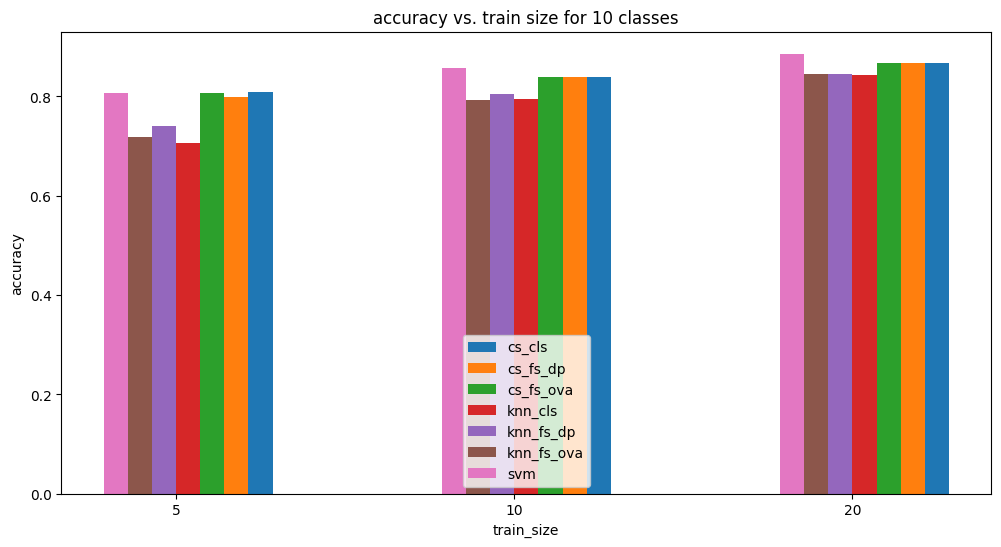

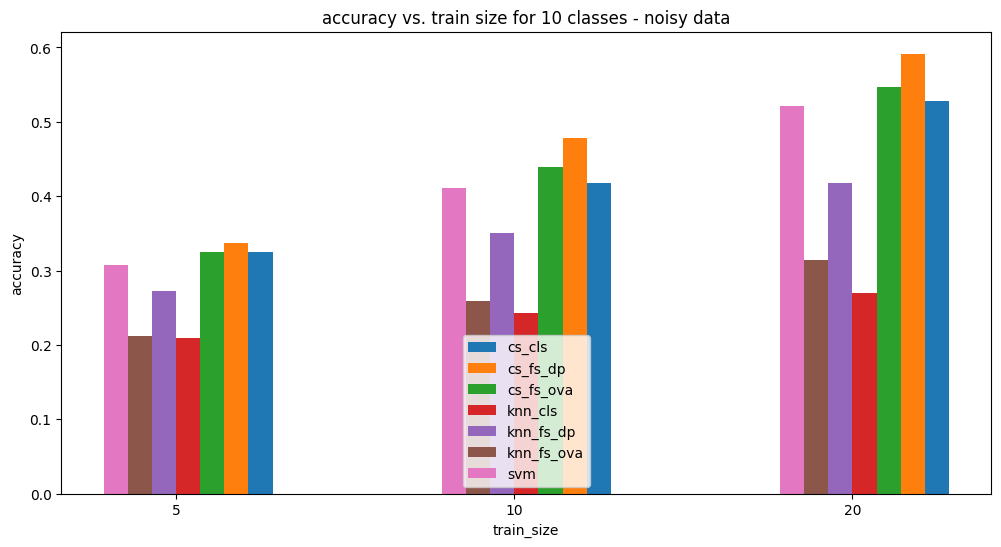

In [16]:
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova, FeatureSelectionDiversityPursuitPermutation
from utils.visualization import bar_plot_scores
gamma = 0.2
train_sizes = [5,10,20]
noise_std = 4
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitAnova(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
dp_perm_fs = FeatureSelectionDiversityPursuitPermutation(hc_gamma=gamma, n_resamples=5000)
# defining classifiers
cs_cls  = CentroidSimilarity()
cs_fs_dp = ClassifierFeatureSelection(cs_cls, dp_fs)
#cs_fs_dp_perm = ClassifierFeatureSelection(cs_cls, dp_perm_fs)
cs_fs_ova = ClassifierFeatureSelection(cs_cls, ova_fs)
knn_cls = KNeighborsClassifier(n_neighbors=train_sizes[0])
knn_fs_dp = ClassifierFeatureSelection(knn_cls, dp_fs)
knn_fs_ova = ClassifierFeatureSelection(knn_cls, ova_fs)
svm_cls = SVC(**best_params)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova, knn_cls, knn_fs_dp, knn_fs_ova, svm_cls]
bar_labels = ['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'knn_cls', 'knn_fs_dp', 'knn_fs_ova', 'svm']
num_experiments = 50
# define possible sizes for the train set (number of train examples per class)
num_classes = 10
accuracies = np.empty((len(classifiers),len(train_sizes),num_experiments))
accuracies_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))

for i in range(len(train_sizes)):
    n = train_sizes[i]
    print(f"Measuring accuracy with {num_classes} classes,  {n} training examples per class")
    print("---------------------------------------------------------------")
    for j in range(num_experiments):
        # sample a label set
        label_set = np.random.choice(a=np.unique(y_train),size=num_classes,replace=False)
        # sample a desired number of examples (feature vectors) for each class
        smpl_idx = []
        test_idcs = []
        for l in label_set:
            cls_idcs = np.squeeze(np.argwhere(y_train == l))
            smpl_idx.extend(list(np.random.choice(cls_idcs,n,replace=False)))
            test_idcs.extend(np.squeeze(np.argwhere(y_test == l)))
        smpl_X_train = X_train[smpl_idx]
        smpl_y_train = y_train[smpl_idx]
        exp_X_test = X_test[test_idcs]
        exp_y_test = y_test[test_idcs]
        accuracies[:,i,j], num_features[:,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers, X_train=smpl_X_train, y_train=smpl_y_train, X_test=exp_X_test, y_test=exp_y_test)

        noisy_smpl_X_train = smpl_X_train + np.random.randn(*smpl_X_train.shape)*noise_std
        noisy_exp_X_test = exp_X_test + np.random.randn(*exp_X_test.shape)*noise_std

        accuracies_w_noise[:,i,j], num_features_w_noise[:,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers, X_train=noisy_smpl_X_train, y_train=smpl_y_train, X_test=noisy_exp_X_test, y_test=exp_y_test)
    print("clean data:")
    for l in range(len(classifiers)):
        print(f"classifier {bar_labels[l]}, mean accuracy is {np.mean(accuracies[l,i,:])}, std accuracy is {np.std(accuracies[l,i,:])}")
    print("\n\n")
    print("noisy data:")
    for l in range(len(classifiers)):
        print(f"classifier {bar_labels[l]}, mean accuracy is {np.mean(accuracies_w_noise[l,i,:])}, std accuracy is {np.std(accuracies_w_noise[l,i,:])}")
    print("\n\n\n")



# plotting results for the clean data
bar_plot_scores(scores=np.mean(accuracies,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='accuracy',
                title=f'accuracy vs. train size for {num_classes} classes')


# plotting results for the noisy data
from utils.visualization import bar_plot_scores
bar_plot_scores(scores=np.mean(accuracies_w_noise,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='accuracy',
                title=f'accuracy vs. train size for {num_classes} classes - noisy data')




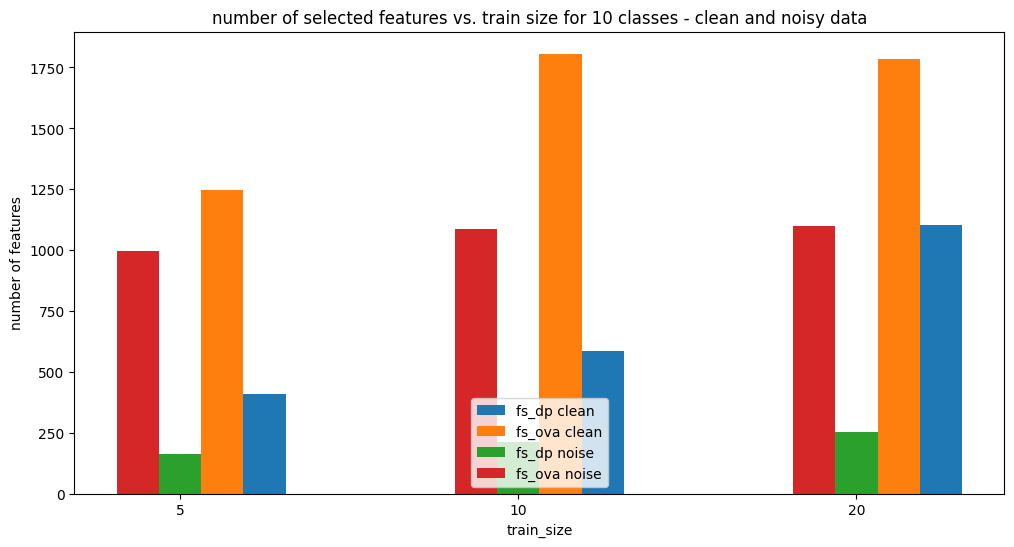

In [17]:
# show the number of features from the clean and the noisy data side by side
num_features_agg = np.concatenate((num_features[[1,2],:,:], num_features_w_noise[[1,2],:,:]), axis=0)
bar_plot_scores(scores=np.mean(num_features_agg,axis=2),
                bar_labels=['fs_dp clean', 'fs_ova clean', 'fs_dp noise', 'fs_ova noise'],
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='number of features',
                title=f'number of selected features vs. train size for {num_classes} classes - clean and noisy data')